# Домашнее задание №2

## 2. Построить график зависимости от количества кадров в последовательности (уменьшать и увеличивать)

### Определение классов и функций

In [5]:
!cp /content/drive/MyDrive/skeletons_20_frames.csv /content/
!cp /content/drive/MyDrive/skeletons_40_frames.csv /content/
!cp /content/drive/MyDrive/skeletons_60_frames.csv /content/

In [6]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [7]:
from torch.utils.data import DataLoader, Dataset

In [8]:
class LSTM_net(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,layer_num,batch_first=True)
        self.dr = torch.nn.Dropout2d(0.1)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        
        
    def forward(self,inputs):
        x = inputs
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [9]:
LABELS = {0: "cheer up", 1: "jump up", 2:  "hand waving", 3: "sitting down", 4: "clapping", 5:"erg"}

In [10]:
skeletons_20 = pd.read_csv("skeletons_20_frames.csv")
#skeletons_30_frames = pd.read_csv("skeletons_30_frames.csv")
skeletons_40 = pd.read_csv("skeletons_40_frames.csv")
#skeletons_50_frames = pd.read_csv("skeletons_50_frames.csv")
skeletons_60 = pd.read_csv("skeletons_60_frames.csv")

In [18]:
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, frames, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        self.labels = self.data.iloc[:,-1]
        self.transform = transform
        self.frames = frames


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(self.frames, 75)
        label = self.labels[idx]
        if self.transform != None:
            item = transform(item)
        return (item, label) 

In [19]:
n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [20]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
#     print(output.topk(5))
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

### Запуск на 20-кадровых данных

In [21]:
skeletons_20_frames = Skeleton_Dataset(file_path = "skeletons_20_frames.csv", frames=20, transform=None)
skeletons_40_frames = Skeleton_Dataset(file_path = "skeletons_40_frames.csv", frames=40, transform=None)
skeletons_60_frames = Skeleton_Dataset(file_path = "skeletons_60_frames.csv", frames=60, transform=None)

In [22]:
skel, lab = skeletons_20_frames.__getitem__(41)
skel.shape

(20, 75)

In [23]:
skel, lab = skeletons_40_frames.__getitem__(41)
skel.shape

(40, 75)

In [24]:
skel, lab = skeletons_60_frames.__getitem__(41)
skel.shape

(60, 75)

In [25]:
int(0.75*len(skeletons_20_frames))

689

In [26]:
int(0.25*len(skeletons_20_frames))

229

In [27]:
len(skeletons_20_frames)

919

In [28]:
train_dataset, test_dataset = torch.utils.data.random_split(skeletons_20_frames, 
                                                            [int(0.75*len(skeletons_20_frames))+1,
                                                             int(0.25*len(skeletons_20_frames))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

In [30]:
from torch import optim
import time
import math

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

all_losses_20 = []
start = time.time()
counter = 0
for epoch in range(600):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses_20.append(current_loss / 25)
        current_loss = 0
    

epoch : 0 iter : 0 (0m 0s) 1.7750  / erg ✗ (jump up)
epoch : 11 iter : 16 (0m 20s) 1.7509  / cheer up ✗ (sitting down)
epoch : 22 iter : 32 (0m 40s) 1.7672  / sitting down ✗ (erg)
epoch : 34 iter : 4 (1m 0s) 1.7015  / cheer up ✗ (sitting down)
epoch : 45 iter : 20 (1m 20s) 1.3610  / sitting down ✗ (jump up)
epoch : 56 iter : 36 (1m 40s) 1.5362  / clapping ✓
epoch : 68 iter : 8 (2m 0s) 1.2955  / clapping ✓
epoch : 79 iter : 24 (2m 20s) 0.9312  / clapping ✓
epoch : 90 iter : 40 (2m 40s) 1.1711  / erg ✓
epoch : 102 iter : 12 (3m 0s) 1.5251  / erg ✗ (clapping)
epoch : 113 iter : 28 (3m 20s) 1.5481  / jump up ✗ (cheer up)
epoch : 125 iter : 0 (3m 40s) 1.2394  / jump up ✗ (sitting down)
epoch : 136 iter : 16 (4m 0s) 0.6877  / erg ✗ (cheer up)
epoch : 147 iter : 32 (4m 20s) 0.7654  / clapping ✓
epoch : 159 iter : 4 (4m 40s) 0.8650  / cheer up ✓
epoch : 170 iter : 20 (5m 0s) 1.0613  / cheer up ✓
epoch : 181 iter : 36 (5m 20s) 0.9079  / sitting down ✓
epoch : 193 iter : 8 (5m 40s) 0.8412  / sit

### Запуск на 40-кадровых данных

In [38]:
n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [36]:
train_dataset, test_dataset = torch.utils.data.random_split(skeletons_40_frames, 
                                                            [int(0.75*len(skeletons_40_frames)),
                                                             int(0.25*len(skeletons_40_frames))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

In [37]:
from torch import optim
import time
import math

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

all_losses_40 = []
start = time.time()
counter = 0
for epoch in range(600):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses_40.append(current_loss / 25)
        current_loss = 0
    

epoch : 0 iter : 0 (0m 0s) 1.7927  / hand waving ✗ (cheer up)
epoch : 11 iter : 38 (0m 38s) 1.7467  / sitting down ✓
epoch : 23 iter : 34 (1m 16s) 1.4825  / cheer up ✓
epoch : 35 iter : 30 (1m 53s) 1.3487  / cheer up ✓
epoch : 47 iter : 26 (2m 31s) 1.6452  / sitting down ✗ (erg)
epoch : 59 iter : 22 (3m 9s) 1.0612  / cheer up ✓
epoch : 71 iter : 18 (3m 47s) 0.8035  / erg ✓
epoch : 83 iter : 14 (4m 25s) 1.0294  / cheer up ✗ (hand waving)
epoch : 95 iter : 10 (5m 2s) 0.9609  / erg ✓
epoch : 107 iter : 6 (5m 40s) 0.9349  / jump up ✓
epoch : 119 iter : 2 (6m 17s) 0.8616  / hand waving ✗ (jump up)
epoch : 130 iter : 40 (6m 55s) 0.7050  / hand waving ✗ (sitting down)
epoch : 142 iter : 36 (7m 32s) 0.8558  / jump up ✓
epoch : 154 iter : 32 (8m 9s) 0.7100  / clapping ✓
epoch : 166 iter : 28 (8m 47s) 0.3470  / clapping ✓
epoch : 178 iter : 24 (9m 25s) 1.0009  / clapping ✓
epoch : 190 iter : 20 (10m 2s) 0.5939  / sitting down ✓
epoch : 202 iter : 16 (10m 39s) 0.9310  / hand waving ✗ (erg)
epoch 

### Запуск на 60-кадровых данных

In [40]:
n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [41]:
from torch import optim
import time
import math

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

all_losses_60 = []
start = time.time()
counter = 0
for epoch in range(600):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses_60.append(current_loss / 25)
        current_loss = 0

epoch : 0 iter : 0 (0m 0s) 1.7804  / clapping ✗ (jump up)
epoch : 11 iter : 38 (0m 37s) 1.7551  / hand waving ✗ (sitting down)
epoch : 23 iter : 34 (1m 14s) 1.7277  / cheer up ✗ (clapping)
epoch : 35 iter : 30 (1m 52s) 1.6438  / cheer up ✗ (hand waving)
epoch : 47 iter : 26 (2m 29s) 1.3784  / sitting down ✗ (jump up)
epoch : 59 iter : 22 (3m 7s) 1.0787  / clapping ✓
epoch : 71 iter : 18 (3m 44s) 1.2384  / jump up ✗ (hand waving)
epoch : 83 iter : 14 (4m 22s) 0.5112  / cheer up ✗ (erg)
epoch : 95 iter : 10 (4m 59s) 0.6709  / cheer up ✓
epoch : 107 iter : 6 (5m 37s) 1.1044  / cheer up ✓
epoch : 119 iter : 2 (6m 14s) 0.6700  / sitting down ✓
epoch : 130 iter : 40 (6m 51s) 1.0030  / cheer up ✓
epoch : 142 iter : 36 (7m 29s) 0.5108  / jump up ✗ (hand waving)
epoch : 154 iter : 32 (8m 6s) 0.7226  / sitting down ✓
epoch : 166 iter : 28 (8m 43s) 0.8443  / clapping ✗ (hand waving)
epoch : 178 iter : 24 (9m 21s) 0.5942  / cheer up ✓
epoch : 190 iter : 20 (9m 58s) 0.6175  / jump up ✓
epoch : 202 

### Сравнение полученных результатов

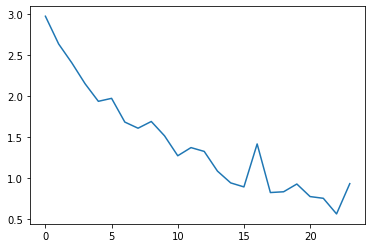

In [31]:
# Количество кадров в последовательности = 20
%matplotlib inline
plt.plot(list(range(0,len(all_losses_20))),all_losses_20)
plt.show()

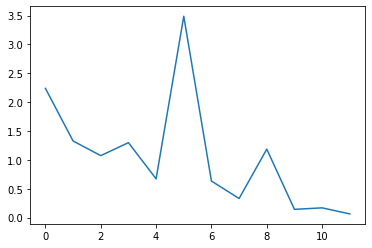

In [39]:
# Количество кадров в последовательности = 40
%matplotlib inline
plt.plot(list(range(0,len(all_losses_40))),all_losses_40)
plt.show()

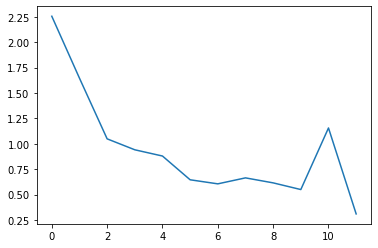

In [42]:
# Количество кадров в последовательности = 60
%matplotlib inline
plt.plot(list(range(0,len(all_losses_60))),all_losses_60)
plt.show()

Наилучший результат при количестве кадров, равном 40

## 3. Построить график зависимости от количества модулей лстм.

### Запуск с 1 модулем

In [43]:
n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 1
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [44]:
train_dataset, test_dataset = torch.utils.data.random_split(skeletons_40_frames, 
                                                            [int(0.75*len(skeletons_40_frames)),
                                                             int(0.25*len(skeletons_40_frames))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

In [45]:
from torch import optim
import time
import math

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate, momentum=0.9)

all_losses_40_1 = []
start = time.time()
counter = 0
for epoch in range(600):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses_40_1.append(current_loss / 25)
        current_loss = 0
    

epoch : 0 iter : 0 (0m 0s) 1.8003  / clapping ✗ (sitting down)
epoch : 11 iter : 38 (0m 25s) 1.6872  / cheer up ✗ (erg)
epoch : 23 iter : 34 (0m 51s) 1.2308  / sitting down ✓
epoch : 35 iter : 30 (1m 17s) 1.1538  / cheer up ✓
epoch : 47 iter : 26 (1m 43s) 0.8901  / clapping ✓
epoch : 59 iter : 22 (2m 9s) 0.9318  / erg ✓
epoch : 71 iter : 18 (2m 34s) 1.0003  / erg ✓
epoch : 83 iter : 14 (3m 0s) 1.1366  / cheer up ✓
epoch : 95 iter : 10 (3m 26s) 0.7822  / hand waving ✗ (jump up)
epoch : 107 iter : 6 (3m 52s) 1.5230  / clapping ✓
epoch : 119 iter : 2 (4m 17s) 0.8537  / jump up ✓
epoch : 130 iter : 40 (4m 43s) 0.7730  / jump up ✓
epoch : 142 iter : 36 (5m 9s) 0.8409  / jump up ✗ (sitting down)
epoch : 154 iter : 32 (5m 34s) 0.9350  / cheer up ✗ (erg)
epoch : 166 iter : 28 (6m 0s) 0.7218  / sitting down ✓
epoch : 178 iter : 24 (6m 26s) 0.9275  / sitting down ✗ (hand waving)
epoch : 190 iter : 20 (6m 51s) 0.5939  / erg ✗ (cheer up)
epoch : 202 iter : 16 (7m 17s) 0.5252  / sitting down ✓
epoc

### Запуск с 3 модулями

In [46]:
n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 3
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=3, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [47]:
train_dataset, test_dataset = torch.utils.data.random_split(skeletons_40_frames, 
                                                            [int(0.75*len(skeletons_40_frames)),
                                                             int(0.25*len(skeletons_40_frames))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

In [48]:
from torch import optim
import time
import math

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate, momentum=0.9)

all_losses_40_3 = []
start = time.time()
counter = 0
for epoch in range(600):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses_40_3.append(current_loss / 25)
        current_loss = 0
    

epoch : 0 iter : 0 (0m 0s) 1.7838  / sitting down ✓
epoch : 11 iter : 38 (0m 49s) 1.7998  / sitting down ✗ (jump up)
epoch : 23 iter : 34 (1m 38s) 1.7763  / clapping ✗ (cheer up)
epoch : 35 iter : 30 (2m 28s) 1.8086  / clapping ✗ (sitting down)
epoch : 47 iter : 26 (3m 18s) 1.8091  / clapping ✗ (erg)
epoch : 59 iter : 22 (4m 7s) 1.7949  / sitting down ✗ (hand waving)
epoch : 71 iter : 18 (4m 57s) 1.7301  / sitting down ✗ (jump up)
epoch : 83 iter : 14 (5m 46s) 1.6696  / clapping ✗ (jump up)
epoch : 95 iter : 10 (6m 35s) 1.3404  / cheer up ✓
epoch : 107 iter : 6 (7m 25s) 1.5689  / sitting down ✗ (clapping)
epoch : 119 iter : 2 (8m 14s) 1.7797  / clapping ✗ (erg)
epoch : 130 iter : 40 (9m 4s) 1.4800  / sitting down ✗ (jump up)
epoch : 142 iter : 36 (9m 53s) 1.5221  / cheer up ✓
epoch : 154 iter : 32 (10m 43s) 1.0398  / sitting down ✓
epoch : 166 iter : 28 (11m 32s) 1.1457  / sitting down ✓
epoch : 178 iter : 24 (12m 21s) 1.2708  / jump up ✓
epoch : 190 iter : 20 (13m 11s) 0.9896  / erg ✓

### Сравнение полученных результатов

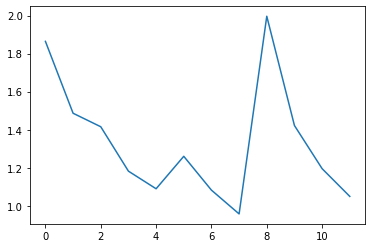

In [50]:
# Количество модулей - 1
%matplotlib inline
plt.plot(list(range(0,len(all_losses_40_1))),all_losses_40_1)
plt.show()

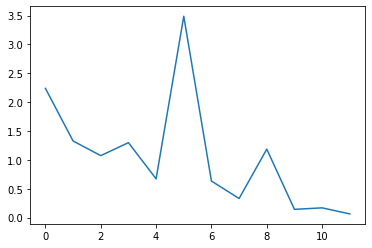

In [49]:
# Количество модулей - 2
%matplotlib inline
plt.plot(list(range(0,len(all_losses_40))),all_losses_40)
plt.show()

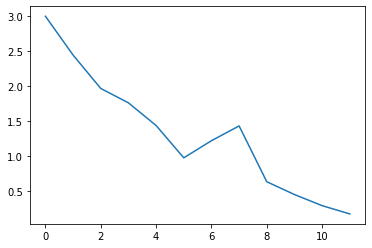

In [51]:
# Количество модулей - 3
%matplotlib inline
plt.plot(list(range(0,len(all_losses_40_3))),all_losses_40_3)
plt.show()

При увеличении числа модулей повышаетя качество, но увеличивается время обучения